## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
from matplotlib import pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
lines = text[TEXT_START : TEXT_END]
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()
lines = [line.lower() for line in lines]

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'

text = ""
for line in lines:
    if len(line) > 15 or len(line) == 1:
        text += line

print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))
print(len(tokens))

38


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
def text_to_matrix(text, token_to_idx):
    matrix = np.zeros((len(text), len(token_to_idx)))
    for i, token in enumerate(text):
        matrix[i, token_to_idx[token]] = 1
    return matrix


def matrix_to_text(matrix, idx_to_token):
    text = []
    for row in matrix:
        text.append(idx_to_token[np.argmax(row)])
    return ''.join(text)


In [7]:
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size=len(tokens), hidden_size=18, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, input_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))


In [8]:
rnn = RNN()

def rnn_loop(rnn, batch_ix):
    batch_size = batch_ix.shape[0]
    h_prev = rnn.init_hidden()
    logits = []

    tensor = torch.LongTensor(batch_ix.argmax(dim=1))
    for x_t in tensor:
        logit_t, h_prev = rnn(x_t, h_prev)
        logits.append(logit_t)

    logits = torch.stack(logits, dim=1)
    logits.squeeze_(0)

    return logits

In [9]:
batch_ix = text_to_matrix(text[:100], token_to_idx)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logit_seq = rnn_loop(rnn, batch_ix)


In [10]:
import random

def train(text, model, optimizer, criterion):
    batch_ix = text_to_matrix(text, token_to_idx)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    target_ix = batch_ix[1:]
    batch_ix = batch_ix[:-1]
            
    logits = rnn_loop(model, batch_ix)
    loss = criterion(logits, target_ix.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    return model, loss.item()

def train_all(text, model, optimizer, criterion, num_epochs=1000):
    losses = []
    len_mini_text = 200
    for epoch in range(num_epochs):
        start = random.randint(0, len(text) - len_mini_text)
        line = text[start : start + len_mini_text]
            
        model, loss = train(line, model, optimizer, criterion)
        losses.append(loss)

        if epoch % 100 == 0:
            print('Epoch: {}, Loss: {:.4f}'.format(epoch, losses[-1]))
    return model, losses


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

rnn, losses = train_all(text, rnn, optimizer, criterion, num_epochs=2000)


Epoch: 0, Loss: 3.7438
Epoch: 100, Loss: 2.4644
Epoch: 200, Loss: 2.1235
Epoch: 300, Loss: 1.7454
Epoch: 400, Loss: 2.3243
Epoch: 500, Loss: 1.8191
Epoch: 600, Loss: 1.9713
Epoch: 700, Loss: 2.0302
Epoch: 800, Loss: 1.8921
Epoch: 900, Loss: 2.0073
Epoch: 1000, Loss: 1.7861
Epoch: 1100, Loss: 1.9906
Epoch: 1200, Loss: 1.8758
Epoch: 1300, Loss: 1.9320
Epoch: 1400, Loss: 1.8952
Epoch: 1500, Loss: 1.7018
Epoch: 1600, Loss: 1.7409
Epoch: 1700, Loss: 1.9090
Epoch: 1800, Loss: 1.9815
Epoch: 1900, Loss: 1.8450


Plot the loss function (axis X: number of epochs, axis Y: loss function).

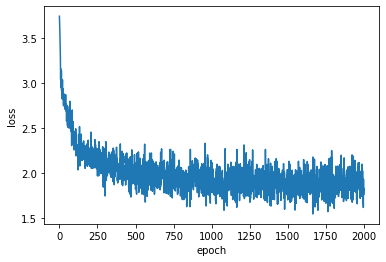

In [12]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [13]:
#generator function for generating text
def generate_sample(rnn, seed_phrase=' hello', max_length=20, temperature=1.0):
    hidden = rnn.init_hidden()

    batch_ix = text_to_matrix(seed_phrase, token_to_idx)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    tensor = torch.LongTensor(batch_ix.argmax(dim=1))
    for p in range(len(seed_phrase) - 1):
        _, hidden = rnn(tensor[p], hidden)
    inp = tensor[-1]

    predicted = seed_phrase

    for p in range(max_length - len(seed_phrase)):
        output, hidden = rnn(inp, hidden)
        
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_char = idx_to_token[int(top_i)]
        predicted += predicted_char
        inp = Variable(torch.tensor([token_to_idx[predicted_char]]))

    return predicted


In [14]:
print(generate_sample(rnn, max_length=500, seed_phrase='sometime too hot', temperature=0.2))

sometime too hoth the thee when the the heart the the thee prove,
  the thing thou i the the when the the the thee thee the the the in thee the bears the thee shave bears,
  the the the the that the the the the the the the then the when and bears
  the in the the the the with the the the shart,
  the that that the the thou the the the thou thee the and the thee thee in thee the thee the thee bears the she with thee the in thee so bears thee the the is thee the beart thee,
  the the the the in th


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [33]:

class RNN_LSTM(nn.Module):
    def __init__(self, input_size=len(tokens), hidden_size=64, n_layers=1):
        super(RNN_LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, input_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input)
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))

In [34]:
rnn_lstm = RNN_LSTM()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_lstm.parameters(), lr=0.001)

rnn_lstm, losses = train_all(text, rnn_lstm, optimizer, criterion, num_epochs=2000)

Epoch: 0, Loss: 3.6260
Epoch: 100, Loss: 2.5360
Epoch: 200, Loss: 2.3868
Epoch: 300, Loss: 2.2427
Epoch: 400, Loss: 2.2785
Epoch: 500, Loss: 2.0254
Epoch: 600, Loss: 1.9847
Epoch: 700, Loss: 1.9525
Epoch: 800, Loss: 1.9993
Epoch: 900, Loss: 2.0418
Epoch: 1000, Loss: 1.7632
Epoch: 1100, Loss: 2.0391
Epoch: 1200, Loss: 1.8145
Epoch: 1300, Loss: 1.9584
Epoch: 1400, Loss: 1.7396
Epoch: 1500, Loss: 1.8191
Epoch: 1600, Loss: 1.8249
Epoch: 1700, Loss: 1.8227
Epoch: 1800, Loss: 1.7829
Epoch: 1900, Loss: 1.5853


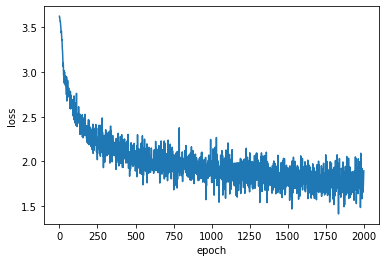

In [35]:
# Plot losses
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [36]:
print(generate_sample(rnn_lstm, max_length=500, seed_phrase='sometime too hot', temperature=0.1))

sometime too hoth the the the the the shath the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the shall the the the the the the the the the the the the the the the the the the the the the so more the the the the the the the the the the the the shall the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


In [37]:
print(generate_sample(rnn_lstm, max_length=500, seed_phrase='her false', temperature=0.2))

her false the the shath the so me the shee the the store sees the the the the the the the shear the the store the the the the the the the the the the so my make the shee the sume the steet the the shath the steest the the and the the start the shall seet the the the stell of the the shall the the the the the the the shee the the the so love the the the the the the the me the shath the shath shath the the the so the shall the so the dear the the the the the the the the the so the the the the the 


In [38]:
print(generate_sample(rnn_lstm, max_length=500, seed_phrase='her false', temperature=0.5))

her false hare thou stor that the to be with thou for that not save the as whe not the so i his thou and, the deting and the the is the shar shath the seest of the sitill deeth the love, co the the manter shal my dest my love thus so you be see his love my love that thou the worthers shear dese some but see the the shee my see the thou then thee of the mades being come for the rear thy so my seet strander whill beart the love the the the the for mught that and my loven is deast that thou  and wi


In [39]:
print(generate_sample(rnn_lstm, max_length=500, seed_phrase='her false', temperature=1.0))

her falseuor youd in me and evel--urp
  nogont:
    nocherfun thou whos, sher thigh this with be swast wriv blave meart, tearthaougnd tortt love it i of iom marne arand wo ifutris thure theseld mided to loth llot,
  a crist gai turn wory the mine to seauty-onc
  thint betold,
    true rure:
     oncaved fours,r's i rivedio, in plme win thou what that ank on whe thic', sarace wis so no demir, 'ues wire fauty then naue wiftathel,
  and hate kamined best bue hist live more look seets nat goy hatare


In [40]:
print(generate_sample(rnn_lstm, max_length=500, seed_phrase='her false', temperature=2.0))

her falsen hid'st-s(elflfcio:-
  riyde bunghfest,
  nuoueh rpempizeik tolqusz sgokiof loog's heqrie; comw hine.rris! ank fuwy 
:iendize am'dl.


!
a h.orreninc;mf)abil bofual.
 !ssr
  i 
ttynpdet, rhif-;
 .(ait, inposy; qute?
  urnove;
 ?
  'eyy fnlnm; wi bveou rengays-h
 wplode;s.
  i stezid vioy;
  hu xirerl'wevtherck:;at
 gode;
   f.une ,ur grvansizue blic! swo,;.
b mmest,
  ykefeoighth hmede,urnmyrg,h
  levk.:
s
  d lksts('aithnnod?
 jrnisakks,
   nod:
  bicp's!
 k thii mzoviemiw:
 tikcex.,-


### CONCLUSION

In my opinion the best text is the one with temperature = $0.5$, probably because is a mid point for which the rnn has enough freedom to generate more complex phrases than just "the the the", and is not that high so that it generates some random text.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [31]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)